# Tutorial 4: Nodes and Graph Validity

In this tutorial, we will discuss [nodes](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html) and the validity of the [graph](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html).

The following will be covered:
- Creating a node
- Adding a node to the graph
- Checking the validity of the graph
- How to make the graph valid (DAG)

In the remainder of this tutorial we will go more into detail on these concepts.

Furthermore, at the end of this notebook you will find exercises.
For the exercises you will have to add/modify a couple of lines of code, which are marked by

```python

# START EXERCISE [BLOCK_NUMBER]

# END EXERCISE [BLOCK_NUMBER]
```

## Pendulum Swing-up

We will create an environment for solving the classic control problem of swinging up an underactuated pendulum, very similar to the [Pendulum-v1 environment](https://www.gymlibrary.ml/environments/classic_control/pendulum/).
Our goal is to swing up this pendulum to the upright position and keep it there, while minimizing the velocity of the pendulum and the input voltage.

Since the dynamics of a pendulum actuated by a DC motor are well known, we can simulate the pendulum by integrating the corresponding ordinary differential equations (ODEs):


$\mathbf{x} = \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix} \\ \dot{\mathbf{x}} = \begin{bmatrix} \dot{\theta} \\ \frac{1}{J}(\frac{K}{R}u - mgl \sin{\theta} - b \dot{\theta} - \frac{K^2}{R}\dot{\theta})\end{bmatrix}$

with $\theta$ the angle w.r.t. upright position, $\dot{\theta}$ the angular velocity, $u$ the input voltage, $J$ the inertia, $m$ the mass, $g$ the gravitational constant, $l$ the length of the pendulum, $b$ the motor viscous friction constant, $K$ the motor constant and $R$ the electric resistance.


## Activate GPU (Colab only)

When in Colab, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down


## Notebook Setup

In order to be able to run the code, we need to install the *eagerx_tutorials* package and ROS.

In [1]:
try:
    import eagerx_tutorials
except ImportError:
    !{"echo 'Installing eagerx-tutorials with pip.' && pip install eagerx-tutorials >> /tmp/eagerx_install.txt 2>&1"}
if 'google.colab' in str(get_ipython()):
    !{"curl 'https://raw.githubusercontent.com/eager-dev/eagerx_tutorials/master/scripts/setup_colab.sh' > ~/setup_colab.sh"}
    !{"bash ~/setup_colab.sh"}

# Setup interactive notebook
# Required in interactive notebooks only.
from eagerx_tutorials import helper
helper.setup_notebook()

Not running on CoLab.
Execute ROS commands as "!...".
ROS noetic available.


## Let's get started

We start by importing the required packages and initializing EAGERx.

In [2]:
import eagerx
import eagerx_tutorials.pendulum  # Registers Pendulum
import eagerx_ode  # Registers OdeEngine

# Initialize eagerx (starts roscore if not already started.)
eagerx.initialize("eagerx_core")

... logging to /home/jelle/.ros/log/a2e1dd5c-dc35-11ec-9aaf-cbc881d02458/roslaunch-jelle-Alienware-m15-R4-42826.log
started roslaunch server http://10.152.153.161:39607/
ros_comm version 1.15.14


SUMMARY

PARAMETERS
 * /rosdistro: noetic
 * /rosversion: 1.15.14

NODES

auto-starting new master
process[master]: started with pid [42890]
ROS_MASTER_URI=http://localhost:11311
setting /run_id to a2e1dd5c-dc35-11ec-9aaf-cbc881d02458
process[rosout-1]: started with pid [42915]
started core service [/rosout]


In this tutorial we will discuss the entity type [nodes](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html).
In the previous tutorials we have showed how to add [object](https://eagerx.readthedocs.io/en/master/guide/api_reference/object/index.html) entities to a [graph](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html).
Apart from objects, we can also add nodes to a graph.
The difference between nodes and objects, is that nodes are engine-agnostic while objects have engine-specific implementations.
Objects are entities that can sense or act in the environments.
Nodes on the other hand can only process data.
A node could for example contain a classifier, PID controller or some sort of signal filter.
While we refer to the incoming and outcoming components of objects as sensors and actuators, a node has inputs and outputs since it cannot act or sense in the environment.

In this tutorial we will create a moving average filter that will act as a low-pass filter on the voltage $u$.
This will prevent sending high frequency voltage signals to the DC motor of the pendulum, since they might damage the motor.
This node is not finished however.
In the exercises you will finalize the implementation of the moving average filter node.

We can create a node by inheriting from the class [`Node`](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html).
This class has the following abstract methods we need to implement:

- [`spec()`](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.spec): Specifies the parameters of the node.
- [`initialize()`](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.initialize): Initializes the node.
- [`reset()`](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.reset): Resets the node at the beginning of an episode.
- [`callback()`](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.callback): Called at the rate of the node.

In [3]:
import eagerx
import eagerx.converters  # Registers space converters
from eagerx.utils.utils import Msg
from std_msgs.msg import Float32, Float32MultiArray


class MovingAverageFilter(eagerx.Node):
    @staticmethod
    @eagerx.register.spec("ExampleNode", eagerx.Node)
    def spec(
        spec,
        name: str,
        rate: float,
        n: int,
    ):
        """
        MovingAverage filter
        :param spec: Not provided by user. Contains the configuration of this node to initialize it at run-time.
        :param name: Node name
        :param rate: Rate at which callback is called.
        :param n: Window size of the moving average
        :return:
        """
        # Performs all the steps to fill-in the params with registered info about all functions.
        spec.initialize(MovingAverageFilter)

        # Modify default node params
        # Default node parameters are: inputs, outputs, states, name, rate, process, color, print_mode and log_level
        # Can be accessed in initialize, reset and callback by self.[parameter_name]
        spec.config.update(name=name, rate=rate, process=eagerx.process.ENVIRONMENT, inputs=["signal"], outputs=["filtered"])

        
        # Custom node params
        # Custom node params become arguments to the initialize method.
        # START EXERCISE 1.1
        # Add the custom parameter *n* (the window size of the moving average filter) to the node specification.

        # START EXERCISE 1.1
        
        # Add space converters
        spec.inputs.signal.space_converter = eagerx.SpaceConverter.make("Space_Float32", -3, 3, dtype="float32")
        spec.outputs.filtered.space_converter = eagerx.SpaceConverter.make("Space_Float32MultiArray", [-3], [3], dtype="float32")
    
    # START EXERCISE 1.2
    # Having added n to the specification, will result in it becoming an argument to the initialize() method. 
    # Also, we need n to be available in reset() and callback(). 
    # Therefore it should be added to self.
    # Furthermore, initialize the moving average with the value 0 by adding a new variable moving_average to self.
    def initialize(self):
        pass
    # END EXERCISE 1.2
    
    @eagerx.register.states()
    def reset(self):
        # START EXERCISE 1.3
        # During a reset at the beginning of the episode, we should make sure that the moving average is reset to 0.
        # So, make sure that the instance variable moving_average you have just created is reset to 0 in reset().
        pass
        # END EXERCISE 1.3

    @eagerx.register.inputs(signal=Float32)
    @eagerx.register.outputs(filtered=Float32MultiArray)
    def callback(self, t_n: float, signal: Msg):
        data = signal.msgs[-1].data
        
        # START EXERCISE 1.4
        # In callback(), the actual moving average should be calculated. 
        # Calculate the moving average recursively, i.e. 𝑎[t]=((𝑛−1)𝑎[𝑡−1]+𝑥[𝑡])/𝑛, 
        # where 𝑎[𝑡] is the moving average at time step 𝑡, 𝑛 is the moving average window size and 𝑥[𝑡] the value of the input signal at time step 𝑡.
        # Make sure you store the resulting moving average in instance variable moving_average.
        filtered_data = data
        # END EXERCISE 1.4
        
        return dict(filtered=Float32MultiArray(data=[filtered_data]))

At this point, we also would like to go a bit more into detail on the graph and its requirements.
The main criterion for the graph to be valid is that there should be no [causal loops](https://en.wikipedia.org/wiki/Causal_loop) when starting from a sensor and following the graph untill we arrive at an actuator.
In other words, if we were to cut the graph at each object, the graph should be a Directed Acyclical Graph ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)).
Otherwise, situations arise in which an infinite loop will be executed within a selection of nodes of the graph.
Intuitively, the DAG requirement ensures that we can only process data from the past and not from the future.

We can think of many situations in which we actually do want to create loops in our graph.
For example, the scenario of state estimation using a Kalman filter is such a situation.
In the figure below we show the graph related to this scenario.
Note that actions and observations are outputs and inputs of the agent, respectively. 
If we were to cut the graphs at the objects (robots), we would see that the resulting graphs are not DAG.

<img src="./figures/tutorial_4_kalman_filter.svg">

**Figure 1:** Examples of a graph that is not DAG.
The red connections indicate the causal loop.
In such situations, the `skip` argument of the [connect](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html?highlight=connect) method should be used to create a valid graph.

In order to construct a valid graph in this scenario, i.e. without causal loops, we can set the `skip` argument of the [connect](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html?highlight=connect) method to `True`.
This will remove the dependency from this source during the first time step.
In the Kalman filtering example we would connect $u$ to the Kalman filter with `skip=True` in order to resolve the causal loop.

Note that if we connect a source to an observation with `skip=True`, we also need to specify `initial_obs` in the [connect()](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html?highlight=connect) method.
This ensures that the dimensions of the observations are consistent for each time step.

For now, we do not need to `skip` any connections, because we have no causal loops.
We will construct a graph similar to ones from the other tutorials, but now we also add the moving average filter node.

In [4]:
# Define rate (depends on rate of ode)
rate = 30.0

# Make moving average filter
moving_average_filter = eagerx.Node.make("ExampleNode", "filter", rate=rate, n=5)

# Make pendulum
pendulum = eagerx.Object.make("Pendulum", "pendulum", actuators=["u"], sensors=["theta", "dtheta", "image"], states=["model_state"])

# Initialize empty graph
graph = eagerx.Graph.create()

# Add pendulum and node to the graph
graph.add([pendulum, moving_average_filter])

# Connect the moving average filter to an action
graph.connect(action="voltage", target=moving_average_filter.inputs.signal)

# Connect the moving average filter to the pendulum
graph.connect(source=moving_average_filter.outputs.filtered, target=pendulum.actuators.u)

# Connect theta and dtheta to observations
graph.connect(source=pendulum.sensors.theta, observation="angle")
graph.connect(source=pendulum.sensors.dtheta, observation="angular_velocity")

# START EXERCISE 2.1
# Connect the output filtered of the node filter to an observation called moving_average in order to restore the Markov property.
# Make sure that the graph is valid after this connection.
# Hint: when connecting to an observation you need to specify an initial observation (initial_obs) in some cases (when skip=True to avoid cycle in the graph).
# This initial observation should be of type `list` or `np.ndarray`.

# END EXERCISE 2.1

# Render image
graph.render(source=pendulum.sensors.image, rate=rate)

# Make OdeEngine
engine = eagerx.Engine.make("OdeEngine", rate=rate)

We can easily check whether the graph that we just constructed is valid and does not contain any causal loops using the [is_valid()](https://eagerx.readthedocs.io/en/master/guide/api_reference/graph/graph.html?highlight=is_valid#eagerx.core.graph.Graph.is_valid) method.
This will return a boolean stating the validity of the graph.
Also, the dependency graphs are plotted for episodes and resets.
These plots can be useful for restoring the validity of the graph, since it will mark cyclic connections red.
For now we are only interested in the episode dependency graph.
The reset dependency graph will be covered in another tutorial.

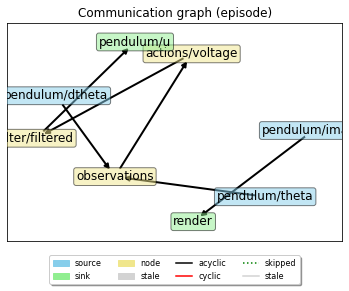

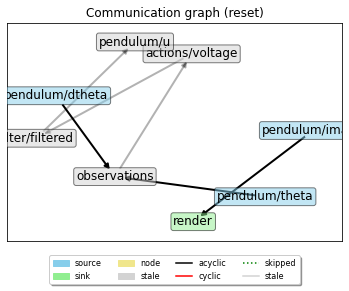

True

In [5]:
graph.is_valid()

If `True` is returned, we are good to go!
Using the [*eagerx_gui* package](https://github.com/eager-dev/eagerx_gui), we see that the graph looks as follows:


```python
graph.gui()
```

<img src="./figures/tutorial_4_gui.svg" width=720>

Next we will define the environment.

In [6]:
from typing import Dict
import numpy as np


class PendulumEnv(eagerx.BaseEnv):
    def __init__(self, name: str, rate: float, graph: eagerx.Graph, engine: eagerx.Engine):
        """Initializes an environment with EAGERx dynamics.

        :param name: The name of the environment. Everything related to this environment
                     (parameters, topics, nodes, etc...) will be registered under namespace: "/[name]".
        :param rate: The rate (Hz) at which the environment will run.
        :param graph: The graph consisting of nodes and objects that describe the environment's dynamics.
        :param engine: The physics engine that will govern the environment's dynamics.
        """
        self.eval = eval
        
        # Maximum episode length
        self.max_steps = 100
        
        # Step counter
        self.steps = None
        super().__init__(name, rate, graph, engine, force_start=True)
    
    def step(self, action: Dict):
        """A method that runs one timestep of the environment's dynamics.

        :params action: A dictionary of actions provided by the agent.
        :returns: A tuple (observation, reward, done, info).

            - observation: Dictionary of observations of the current timestep.

            - reward: amount of reward returned after previous action

            - done: whether the episode has ended, in which case further step() calls will return undefined results

            - info: contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        """
        # Take step
        observation = self._step(action)
        self.steps += 1
        
        # Get angle and angular velocity
        # Take first element because of window size (covered in other tutorial)
        th = observation["angle"][0] 
        thdot = observation["angular_velocity"][0]

        # Convert from numpy array to float
        u = float(action["voltage"])

        # Calculate cost
        # Penalize angle error, angular velocity and input voltage
        cost = th**2 + 0.1 * thdot**2 + 0.001 * u**2  

        # Determine when is the episode over
        # currently just a timeout after 100 steps
        done = self.steps > self.max_steps

        # Set info, tell the algorithm the termination was due to a timeout
        # (the episode was truncated)
        info = {"TimeLimit.truncated": self.steps > self.max_steps}

        return observation, -cost, done, info
    
    def reset(self) -> Dict:
        """Resets the environment to an initial state and returns an initial observation.

        :returns: The initial observation.
        """
        # Determine reset states
        states = self.state_space.sample()
            
        # Perform reset
        observation = self._reset(states)

        # Reset step counter
        self.steps = 0
        return observation

Next, we will use [Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/) to learn a policy, just like we did in the first three tutorials.

In [7]:
import numpy as np
from typing import Dict
import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from eagerx.wrappers import Flatten


# Initialize Environment
env = PendulumEnv(name="PendulumEnv", rate=rate, graph=graph, engine=engine)

# Toggle render
env.render("human")

# Stable Baselines3 expects flattened actions & observations
# Convert observation and action space from Dict() to Box()
env = Flatten(env)

# Check that env follows Gym API and returns expected shapes
check_env(env)

# Initialize learner
model = sb3.SAC("MlpPolicy", env, verbose=1)

# Train for 1 minute (sim time)
model.learn(total_timesteps=int(60 * rate))

env.shutdown()

[INFO] [1653488347.772300]: Node "/PendulumEnv/env/supervisor" initialized.
[INFO] [1653488347.922165]: Node "/PendulumEnv/engine" initialized.
[INFO] [1653488348.048157]: Node "/PendulumEnv/environment" initialized.
[INFO] [1653488348.115774]: Node "/PendulumEnv/filter" initialized.
[INFO] [1653488348.189785]: Waiting for nodes "['env/render']" to be initialized.
[INFO] [1653488348.210069]: Node "/PendulumEnv/pendulum/theta" initialized.
[INFO] [1653488348.234685]: Node "/PendulumEnv/pendulum/dtheta" initialized.


/home/jelle/.cache/pypoetry/virtualenvs/eagerx-tutorials-NkxrhtGC-py3.8/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


[INFO] [1653488348.307016]: Adding object "pendulum" of type "Pendulum" to the simulator.
[INFO] [1653488348.320382]: Node "/PendulumEnv/pendulum/x" initialized.
[INFO] [1653488348.335675]: Node "/PendulumEnv/pendulum/image" initialized.
[INFO] [1653488348.335951]: [pendulum/image] START RENDERING!
[INFO] [1653488348.349912]: Node "/PendulumEnv/pendulum/u" initialized.
[INFO] [1653488348.366327]: Node "/PendulumEnv/pendulum/u_applied" initialized.
[INFO] [1653488349.421094]: Nodes initialized.
[INFO] [1653488349.583169]: Pipelines initialized.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 101       |
|    ep_rew_mean     | -1.37e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 80        |
|    time_elapsed    | 5         |
|    total_timesteps | 404       |
| train/             |           |
|    

# Exercises

In these exercises you finalize the implementation of the moving average filter node.
Furthermore, the Markov property will be violated after implementing the moving average filter.
You will restore the Markov property, which will also require you to consider the graph validity.

For these exercises, you will need to modify or add some lines of code in the cells above.
These lines are indicated by the following comments:

```python
# START EXERCISE [BLOCK_NUMBER]

# END EXERCISE [BLOCK_NUMBER]
```

However, feel free to play with the other code as well if you are interested.
We recommend you to restart and run all code after each section (in Colab there is the option *Restart and run all* under *Runtime*).


## 1. Finalize the moving average filter

In the code as provided above, the implementation of the moving average filter is not yet finalized.
Currently, it just outputs the input signal without applying any filtering.
Finalize the filter such that moving average filtering is applied to the acuator $u$.


### Add your code to the following blocks: 

1.1 Add the custom parameter *n* (the window size of the moving average filter) to the node specification.  
1.2 Having added *n* to the specification, will result in it becoming an argument to the [initialize()](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.initialize) method.
Also, we need *n* to be available in [reset()](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.reset) and [callback()](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.callback).
Therefore it should be added to `self`.
Furthermore, initialize the moving average with the value 0 by adding a new variable *moving_average* to `self`.  
1.3 During a reset at the beginning of the episode, we should make sure that the moving average is reset to 0.
So, make sure that the instance variable *moving_average* you have just created is reset to 0 in [reset()](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.reset).  
1.4 In [callback()](https://eagerx.readthedocs.io/en/master/guide/api_reference/node/node.html#eagerx.core.entities.Node.callback), the actual moving average should be calculated.
Calculate the moving average recursively, i.e. $a_t = \frac{(n-1)a_{t-1} + x_t}{n}$, where $a_t$ is the moving average at time step $t$, $n$ is the moving average window size and $x_t$ the value of the input *signal* at time step $t$.
Make sure you store the resulting moving average in instance variable *moving_average*.


## 2. Restore the Markov property

After implementing the moving average filter, we have violated the [Markov property](http://www.incompleteideas.net/book/ebook/node32.html).
Namely, the state is no longer memoryless due to the filtering procedure.
We can restore the markov property by adding the moving average, i.e. output *filtered* of the *filter* node, as an observation to the agent.

After this the graph should look as follows:

<img src="./figures/tutorial_42_gui.svg" width=720>

However, if we naively connect *filtered* to an observation and now run

```python
graph.is_valid()
```

we get the following output:

<img src="./figures/tutorial_42_communication_graph.svg" width=420>

Here we see that this results in a causal loop between *actions/voltage*, *filter/filtered* and *observations*.
Therefore, you need to consider the graph validity when creating this connection.

### Add your code to the following blocks: 

2.1 Connect the output *filtered* of the node *filter* to an observation called *moving_average* in order to restore the Markov property.
Make sure that the graph is valid after this connection.

*Hint*: when connecting to an observation you need to specify an initial observation (`initial_obs`) in some cases (when `skip=True` to avoid cycle in the graph).
This initial observation should be of type `list` or `np.ndarray`.